# Демо-экзамен по курсу "Прикладной анализ данных". Вариант 1

Выполнил: **НИЯУ МИФИ** Б23-215 **Донецков Андрей Дмитриевич**.

Вставьте ниже скриншот с результатом вашего решения в Leaderboard на Kaggle: https://www.kaggle.com/competitions/where-are-the-seagulls

*Пример ниже:*

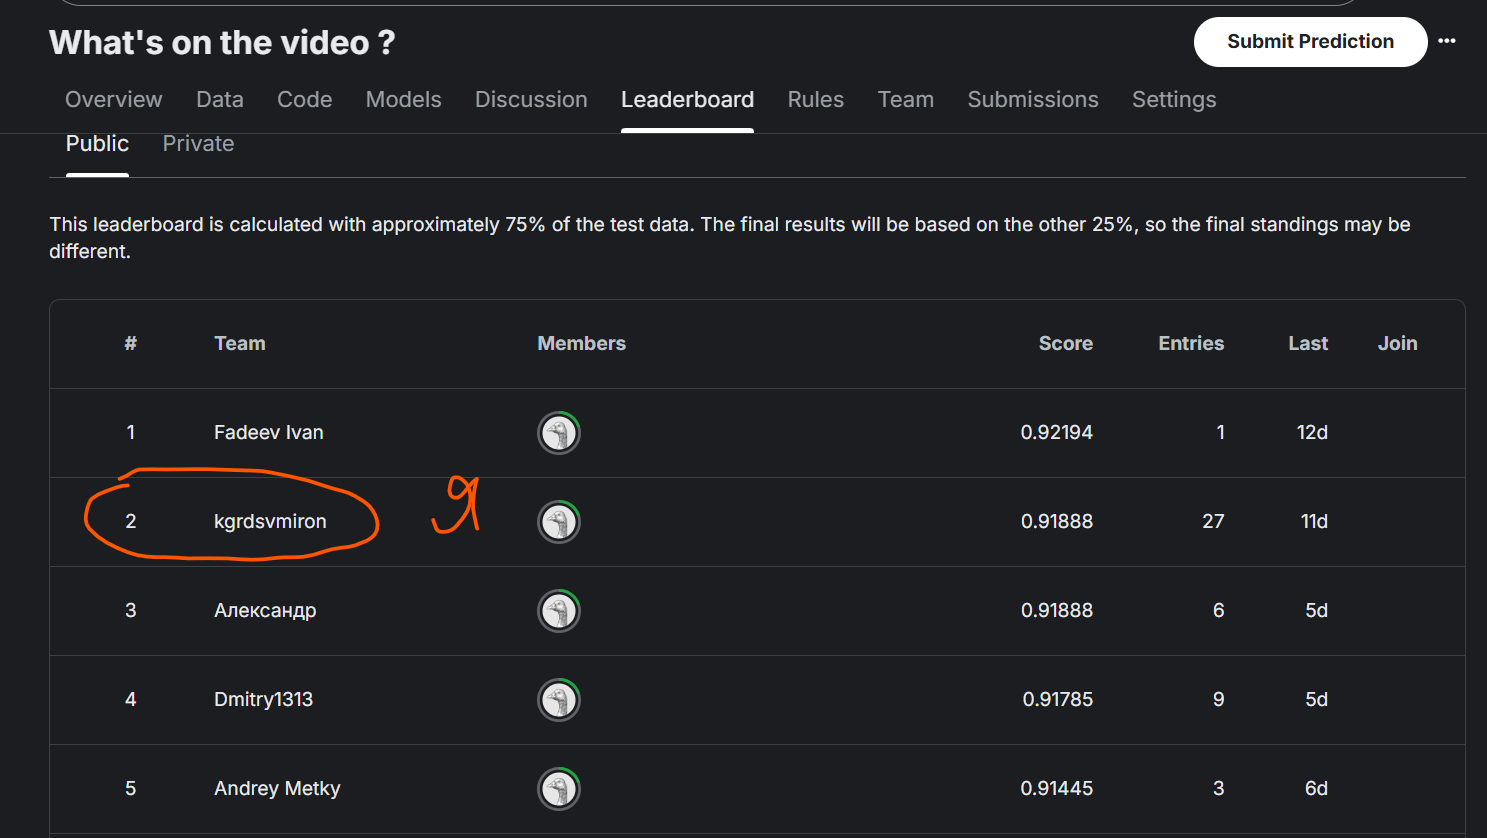

## 0. Описание задачи и данные

В 4 километрах от тихоокеанского берега Камчатки в бухте Вестник лежит остров Уташуд — часть Южно-Камчатского федерального заказника. На нем живут каланы, антуры, тюлени ларги, около 50 тысяч птиц десяти разных видов, включая  колонию топорика численностью 10 тыс. пар. В данной задаче нас интересуют двое обитатаелей острова – ларга и техоокеанская чайка, за которыми осуществляется наблюдение через фотоловушки в летний сезон.

На Уташуде находится репродуктивное лежбище тюленей-ларга  и одно из крупнейших на Камчатке поселений тихоокеанской чайки (4 тыс. пар). За 1 сезон наблюдения за этими животными может накопится более 1800 фотографий различного качества. Через эти фотографии инспекторы оценивают благополучие и численность животных.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/where-are-the-seagulls

In [1]:
# Import libraries
# TODO

import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2


Небольшая инструкция как напрямую скачать данные с kaggle в Colab ноутбук: https://www.geeksforgeeks.org/python/how-to-import-kaggle-datasets-directly-into-google-colab/

In [2]:
import opendatasets as od

url = 'https://www.kaggle.com/competitions/where-are-the-seagulls'
od.download(url)

Skipping, found downloaded files in "./where-are-the-seagulls" (use force=True to force download)


In [3]:
train_images_path = "where-are-the-seagulls/data/train/images/"
train_labels_path = "where-are-the-seagulls/data/train/labels/"
test_images_path = "where-are-the-seagulls/data/test/images/"

train_images_path_array = [train_images_path + entry.name for entry in os.scandir(train_images_path) if entry.is_file()]
train_labels_path_array = [train_labels_path + entry.name for entry in os.scandir(train_labels_path) if entry.is_file()]
test_images_path_array = [test_images_path + entry.name for entry in os.scandir(test_images_path) if entry.is_file()]

In [4]:
combined_list = []

for label_path in train_labels_path_array:
    if os.path.getsize(label_path) > 0:
        temp_df = pd.read_csv(label_path, header=None, sep='\s+')
        temp_df['file_name'] = label_path
        combined_list.append(temp_df)

label_df = pd.concat(combined_list, ignore_index=True)
label_df.columns = ['label', 'x_center', 'y_center', 'width', 'height', 'file_name']
label_df = label_df[['file_name', 'label', 'x_center', 'y_center', 'width', 'height']]

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_411573/3944526556.py:5: SyntaxWarning: invalid escape sequence '\s'
  temp_df = pd.read_csv(label_path, header=None, sep='\s+')


## 1. Предварительное исследование данных

### Глянем на соотношения.

In [5]:
print(len(train_images_path_array), len(test_images_path_array))

500 99


> Можно и проще сделать вручную. Ну да ладно.

### Визуализирование рабочих фотографий.

In [6]:
# Посмотреть на изображения из папки
def look_images(imgage_path: str, resolutin: list) -> None:
    from random import sample

    num_samples = min(resolutin[0] * resolutin[1], len(imgage_path))
    sampled_paths = sample(imgage_path, num_samples)

    fig, axes = plt.subplots(resolutin[1], resolutin[0], figsize=(resolutin[0] * 4, resolutin[1] * 4))
    axes_flat = axes.flat

    for idx, ax in enumerate(axes_flat):
        if idx < num_samples:
            image = cv2.imread(sampled_paths[idx])
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Посмотрим на 15 изображений из **train**.

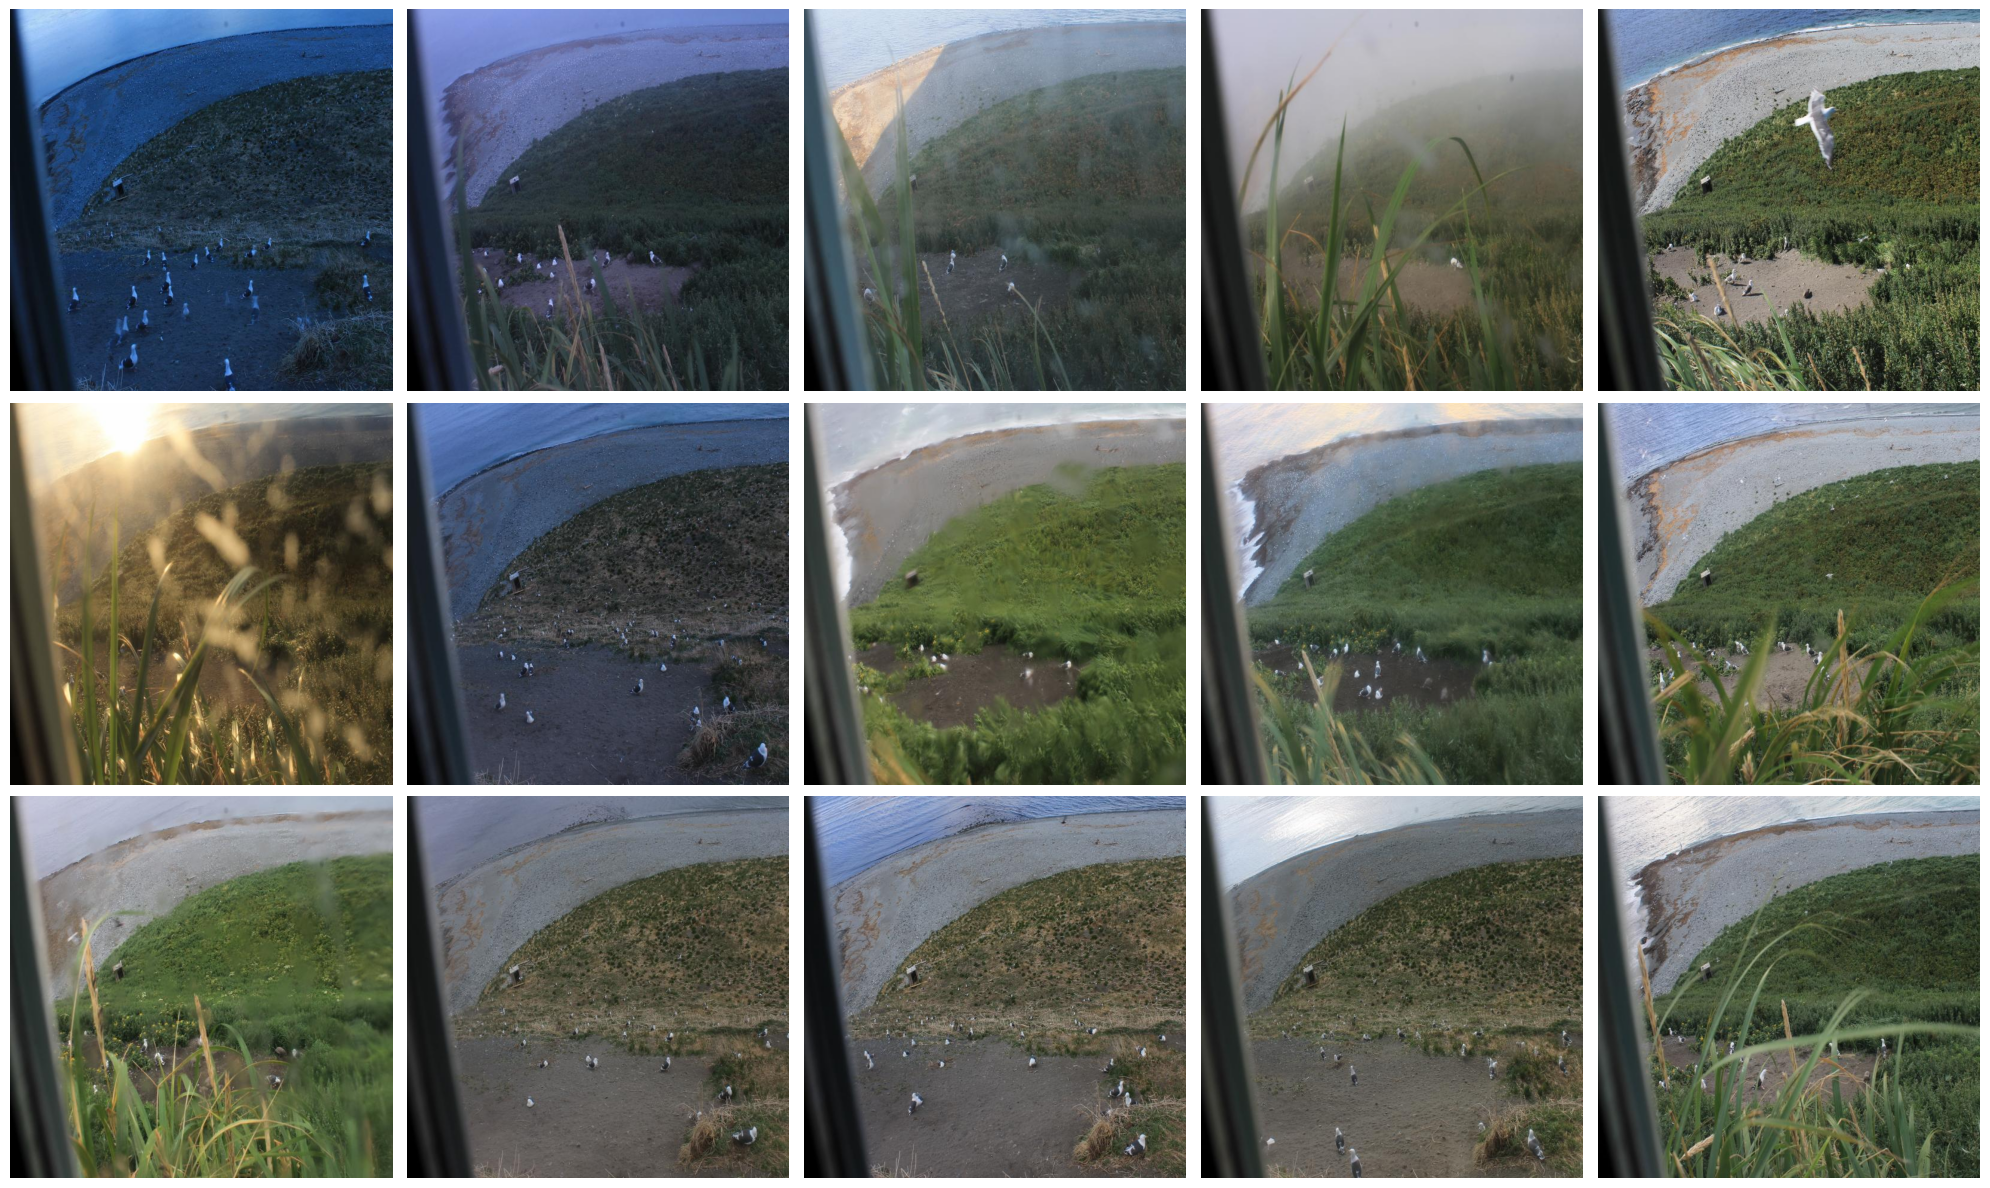

In [7]:
look_images(train_images_path_array, [5, 3])

Посмотрим на 15 изображений из **test**.

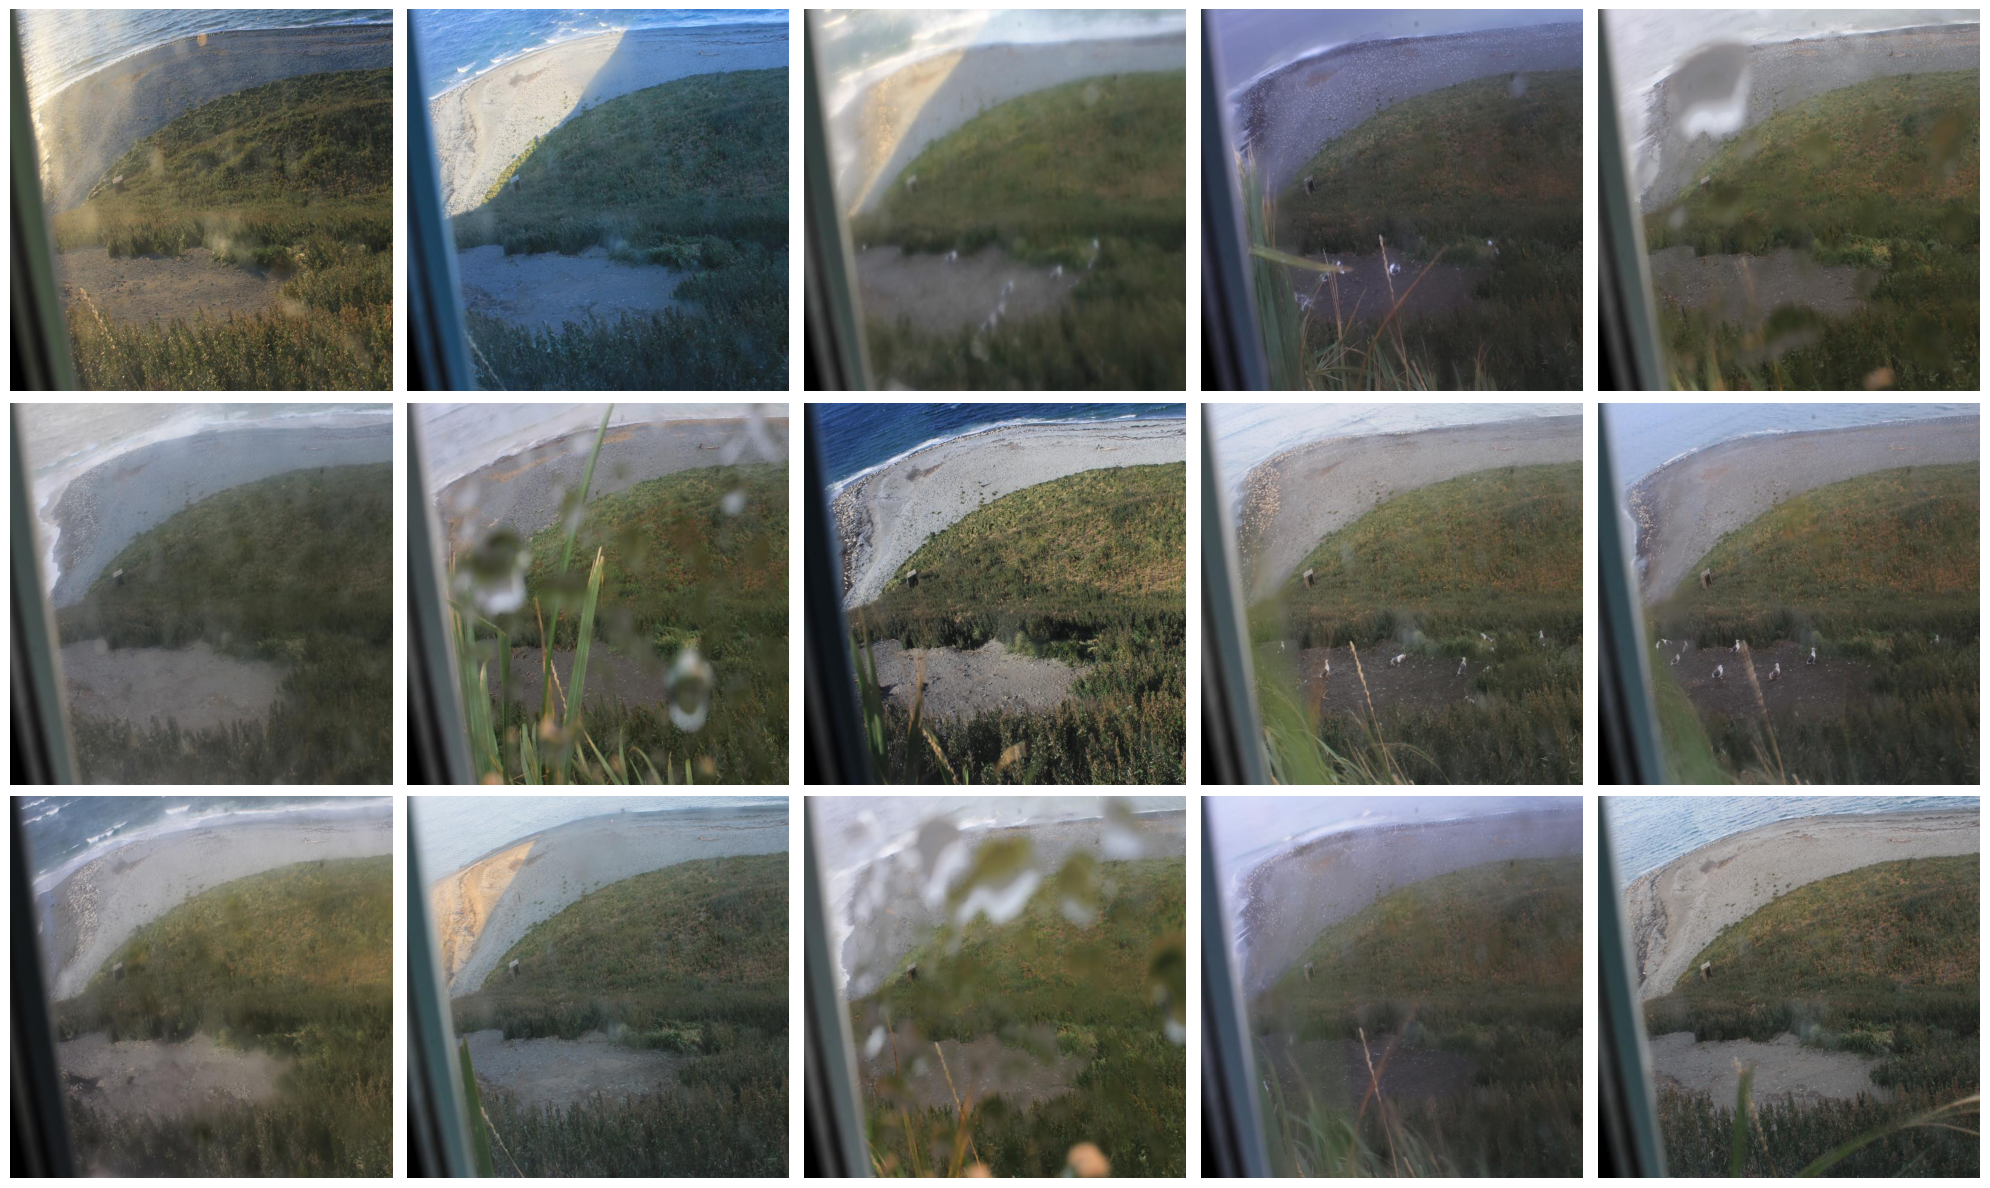

In [8]:
look_images(test_images_path_array, [5, 3])

1) Видно только чаек, где тюлени?
2) Похоже, что все фотографии были сделаны в одном и том же месте. Можно сразу отмести несколько вариантов изменения фотографий, например поворот и сдвиг.

In [9]:
label_df

file_name  label  x_center  \
0     where-are-the-seagulls/data/train/labels/20200...      0  0.178125   
1     where-are-the-seagulls/data/train/labels/20200...      0  0.178906   
2     where-are-the-seagulls/data/train/labels/20200...      0  0.290625   
3     where-are-the-seagulls/data/train/labels/20200...      0  0.364063   
4     where-are-the-seagulls/data/train/labels/20200...      0  0.406250   
...                                                 ...    ...       ...   
5381  where-are-the-seagulls/data/train/labels/20200...      0  0.657813   
5382  where-are-the-seagulls/data/train/labels/20200...      0  0.523438   
5383  where-are-the-seagulls/data/train/labels/20200...      0  0.371094   
5384  where-are-the-seagulls/data/train/labels/20200...      0  0.364063   
5385  where-are-the-seagulls/data/train/labels/20200...      0  0.766406   

      y_center     width    height  
0     0.648438  0.017188  0.032031  
1     0.678906  0.029687  0.029687  
2     0.697656  0.035937  0.028125  
3     0.663281  0.027344  0.037500  
4     0.771094  0.023438  0.066406  
...        ...       ...       ...  
5381  0.666406  0.022656  0.058594  
5382  0.721094  0.029687  0.050781  
5383  0.653125  0.021094  0.036719  
5384  0.697656  0.018750  0.026562  
5385  0.620313  0.025000  0.032813  

[5386 rows x 6 columns]

In [10]:
label_df["label"].unique()

array([0])

Значит разбираться будем только с чайками. Посмотрим на из расположение

<Figure size 640x480 with 0 Axes>

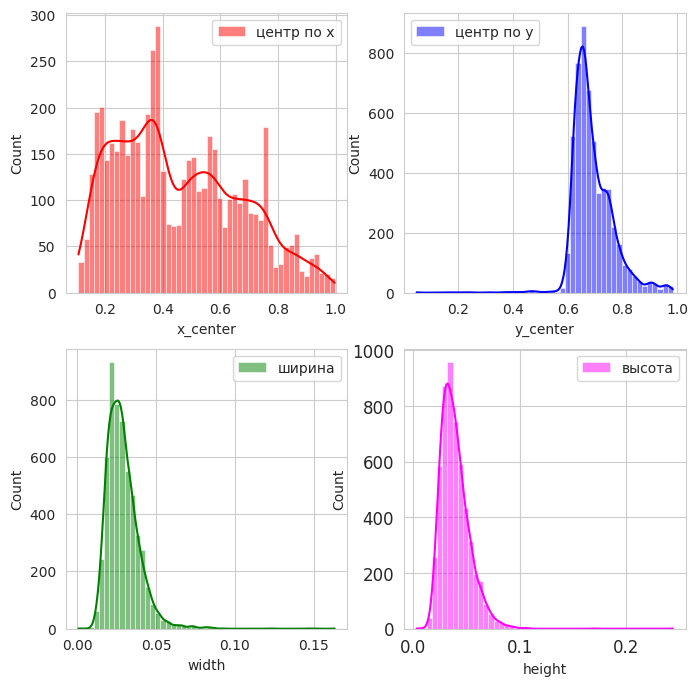

In [11]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

sns.histplot(label_df["x_center"], kde=True, bins=50, color="red", ax=ax[0, 0], label='центр по х')
sns.histplot(label_df["y_center"], kde=True, bins=50, color="blue", ax=ax[0, 1], label='центр по у')
sns.histplot(label_df["width"], kde=True, bins=50, color="green", ax=ax[1, 0], label='ширина')
sns.histplot(label_df["height"], kde=True, bins=50, color="magenta", ax=ax[1, 1], label='высота')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


Видно, что объекты (в будующем просто - чайки) распологаются внизу изображений и примерно одного размера, что логично из того, что у нас изображения одного и тогоже места, а чайки поодали под окном. Посмоторим на исключения.

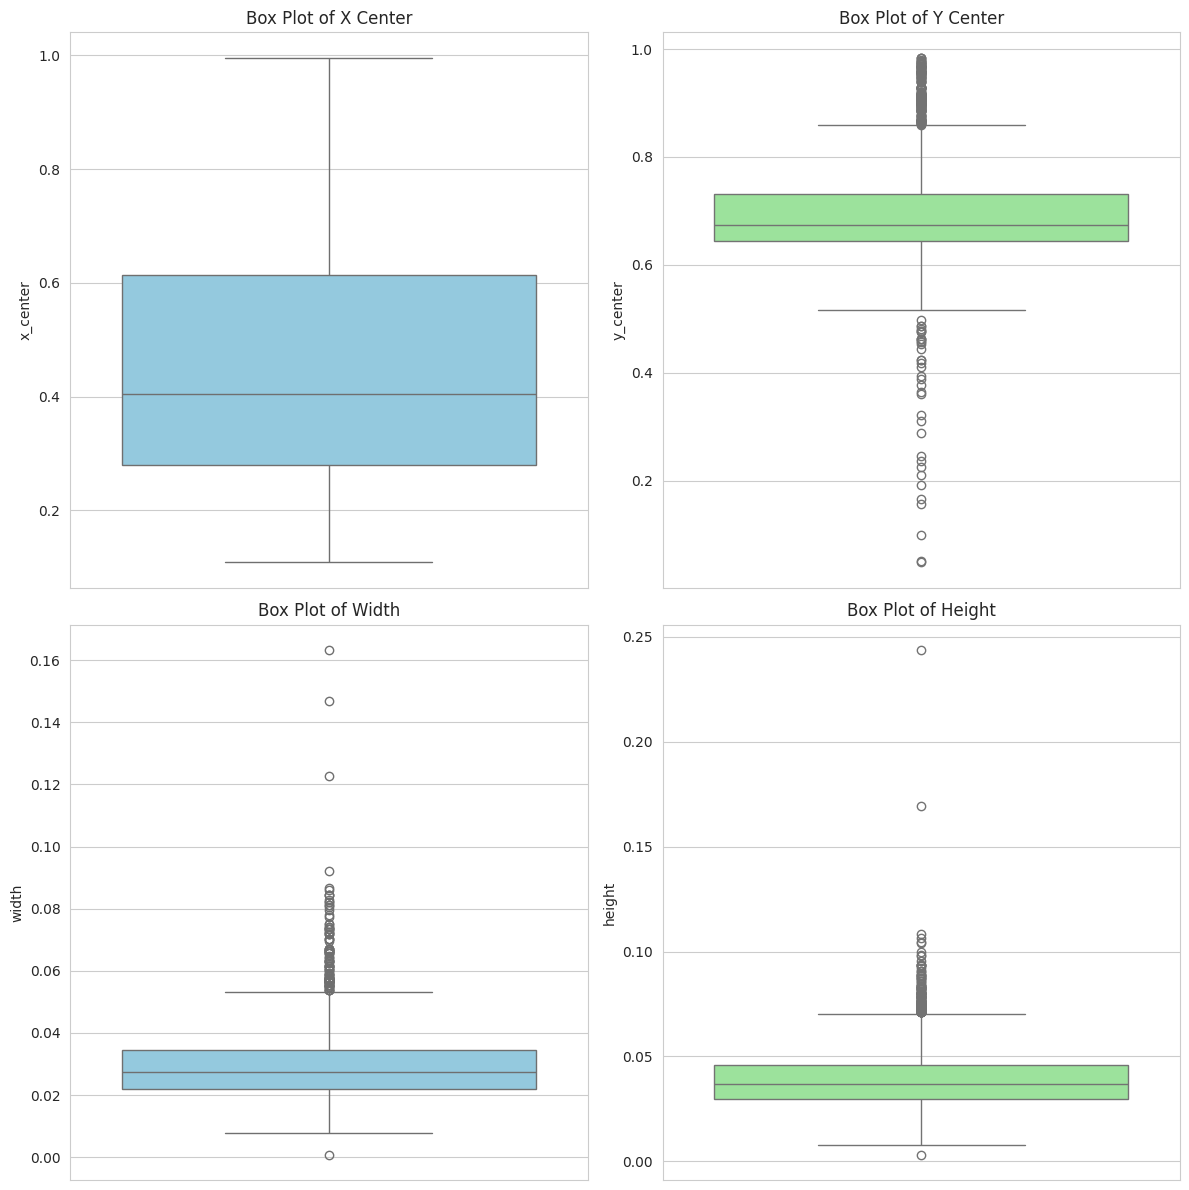

In [12]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.boxplot(y=label_df["x_center"], color='skyblue')
plt.title('Box Plot of X Center')

plt.subplot(2, 2, 2)
sns.boxplot(y=label_df["y_center"], color='lightgreen')
plt.title('Box Plot of Y Center')

plt.subplot(2, 2, 3)
sns.boxplot(y=label_df["width"], color='skyblue')
plt.title('Box Plot of Width')

plt.subplot(2, 2, 4)
sns.boxplot(y=label_df["height"], color='lightgreen')
plt.title('Box Plot of Height')

plt.tight_layout()
plt.show()

Выглядит интересно. По x исключений нет, по y все хаотично, а из размеров двух чаех можно догадаться, что они сели прям у окна.

Но в общем можно ожидать хорошую обучаемость нейронной сети из за плюс-минус нормальгого распределения. Приступим.

## 2. Подготовка данных для обучения

Скучная часть. Ничего интересного.

In [ ]:
# Скопировать данные для дальнейшей постобработки, плюс разделить данные на валидационную и тренировучную выборки
def dynamic_split(split_ratio=0.8) -> None:
    import random
    from sklearn.model_selection import train_test_split
    import shutil

    data_root = "data"
    old_dir = "where-are-the-seagulls/data"
    old_train_dir = os.path.join(old_dir, "train/")
    old_test_dir = os.path.join(old_dir, "test/")
    train_dir = os.path.join(data_root, "train/")
    val_dir = os.path.join(data_root, "val/")
    test_dir = os.path.join(data_root, "test/")

    shutil.rmtree(data_root, ignore_errors=True)
    os.makedirs(os.path.join(train_dir, "images"))
    os.makedirs(os.path.join(train_dir, "labels"))
    os.makedirs(os.path.join(val_dir, "images"))
    os.makedirs(os.path.join(val_dir, "labels"))

    old_image_dir = os.path.join(old_train_dir, "images")
    all_images = [f for f in os.listdir(old_image_dir) if f.endswith('.jpg')]
    random.shuffle(all_images)

    train_files, val_files = train_test_split(
        all_images, 
        train_size=split_ratio,
        random_state=random.randint(0, 1000)
    )

    def copy_files(file_list, target_dir):
        for img_file in file_list:
            src_img = os.path.join(old_train_dir, "images", img_file)
            dst_img = os.path.join(target_dir, "images", img_file)
            shutil.copy(src_img, dst_img)

            label_file = img_file.replace(".jpg", ".txt")
            src_label = os.path.join(old_train_dir, "labels", label_file)
            dst_label = os.path.join(target_dir, "labels", label_file)
            shutil.copy(src_label, dst_label)

    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)
    shutil.copytree(os.path.join(old_test_dir, "images"), os.path.join(test_dir, "images"))

In [ ]:
# Искуственное увеличение выборки
def apply_albumentations_to_train_data(augmentation_pipeline, num_augmentations_per_image=1) -> None:
    from tqdm import tqdm
    
    data_root = "data"
    old_dir = "where-are-the-seagulls/data"
    train_dir = os.path.join(old_dir, "train/")
    augmented_train_dir = os.path.join(data_root, "train/")
    
    shutil.rmtree(augmented_train_dir, ignore_errors=True)
    os.makedirs(os.path.join(augmented_train_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(augmented_train_dir, "labels"), exist_ok=True)
    
    train_images_dir = os.path.join(train_dir, "images")
    train_labels_dir = os.path.join(train_dir, "labels")
    train_images = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
    
    for img_file in tqdm(train_images, desc="Applying augmentations"):
        img_path = os.path.join(train_images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label_file = img_file.replace(".jpg", ".txt")
        label_path = os.path.join(train_labels_dir, label_file)
        bboxes = []
        class_labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, xc, yc, w, h = map(float, line.split())
                    bboxes.append([xc, yc, w, h])
                    class_labels.append(class_id)
        
        for aug_idx in range(num_augmentations_per_image):
            transformed = augmentation_pipeline(
                image=image,
                bboxes=bboxes,
                class_labels=class_labels
            )
            t_img = transformed['image']
            t_bboxes = transformed['bboxes']
            t_class_labels = transformed['class_labels']
            
            base_name = os.path.splitext(img_file)[0]
            new_img_name = f"{base_name}_aug{aug_idx}.jpg"
            new_label_name = f"{base_name}_aug{aug_idx}.txt"
            
            cv2.imwrite(
                os.path.join(augmented_train_dir, "images", new_img_name),
                cv2.cvtColor(t_img, cv2.COLOR_RGB2BGR)
            )

            with open(os.path.join(augmented_train_dir, "labels", new_label_name), 'w') as f:
                for cls, bbox in zip(t_class_labels, t_bboxes):
                    f.write(f"{int(cls)} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")


def get_augmentation_pipeline():
    import albumentations as A
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.4),
        A.RandomRain(drop_width=1, blur_value=2, p=0.3),
        A.GlassBlur(max_delta=2, p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
        A.GaussNoise(p=0.3),
        A.ImageCompression(p=0.2),
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels']
    ))

In [15]:
dynamic_split(split_ratio=0.8)

pipeline = get_augmentation_pipeline()
apply_albumentations_to_train_data(
    augmentation_pipeline=pipeline,
    num_augmentations_per_image=4
)

Applying augmentations: 100%|██████████| 500/500 [00:20<00:00, 24.32it/s]


## 3. Реализация модели, её обучение и получение результатов

In [16]:
from ultralytics import YOLO

model = YOLO("yolo11x.pt")

In [ ]:
results = model.train(data="dataset.yaml", epochs=10)
results = model.val()

New https://pypi.org/project/ultralytics/8.3.165 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24081MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False,

train: Scanning /home/andredon/projects/ADA/Homework_final/data/train/labels... 2000 images, 128 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<00:00, 9717.33it/s]

train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug0.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug1.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug2.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug3.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68_aug0.jpg: 3 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68_aug1.jpg: 3 duplicate labels removed
train: /home/and

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3605.5±1215.3 MB/s, size: 65.3 KB)


val: Scanning /home/andredon/projects/ADA/Homework_final/data/val/labels... 100 images, 3 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 7723.32it/s]

val: New cache created: /home/andredon/projects/ADA/Homework_final/data/val/labels.cache


Plotting labels to /home/andredon/projects/ADA/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/andredon/projects/ADA/runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      14.7G      2.333       1.82      1.283        176        640: 100%|██████████| 125/125 [00:28<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]

                   all        100       1155      0.182      0.337      0.127      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      15.4G      2.327      1.616      1.282        183        640: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

                   all        100       1155   3.33e-05   0.000866   1.69e-05   5.08e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      15.4G      2.319      1.593      1.261        164        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]

                   all        100       1155      0.464      0.337      0.304      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      15.7G      2.242      1.489      1.238        111        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.56it/s]

                   all        100       1155      0.772       0.73      0.769      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      15.6G       2.18      1.412       1.21        211        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all        100       1155      0.831      0.693      0.779      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      15.4G      2.135      1.327      1.193        121        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]

                   all        100       1155      0.839       0.75       0.82      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      15.6G      2.093       1.27      1.172        153        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.60it/s]

                   all        100       1155      0.845      0.758      0.827      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      15.6G      2.048      1.231      1.162        195        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

                   all        100       1155      0.845      0.784      0.852      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      15.6G      2.011      1.194       1.15        135        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

                   all        100       1155      0.905      0.761      0.859      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      15.5G      1.955      1.141      1.132        151        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all        100       1155      0.893      0.803      0.873      0.429



10 epochs completed in 0.080 hours.
Optimizer stripped from /home/andredon/projects/ADA/runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from /home/andredon/projects/ADA/runs/detect/train/weights/best.pt, 114.4MB

Validating /home/andredon/projects/ADA/runs/detect/train/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24081MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


                   all        100       1155      0.892      0.803      0.873      0.429
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /home/andredon/projects/ADA/runs/detect/train
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24081MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4246.5±1392.4 MB/s, size: 50.6 KB)


val: Scanning /home/andredon/projects/ADA/Homework_final/data/val/labels.cache... 100 images, 3 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]


                   all        100       1155      0.893      0.801      0.872       0.43
Speed: 0.6ms preprocess, 7.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /home/andredon/projects/ADA/runs/detect/train2


In [ ]:
results = model.predict("where-are-the-seagulls/data/test/images")


image 1/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200928_150507_01_JPG.rf.109359154a680b75a67dce1e82062e55.jpg: 640x640 (no detections), 6.9ms
image 2/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200928_160525_01_JPG.rf.50f3289f065a9a4f5372ffa3df9e7265.jpg: 640x640 (no detections), 6.9ms
image 3/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200928_180600_01_JPG.rf.df87e688ee0e009c3a06572a4997cf81.jpg: 640x640 (no detections), 6.9ms
image 4/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200929_081017_01_JPG.rf.c0e8134223d6ed61ac5187cc29495bd9.jpg: 640x640 (no detections), 6.9ms
image 5/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200929_091035_01_JPG.rf.cc0f7b275eb3a5dd680df0011fa46c36.jpg: 640x640 (no detections), 6.9ms
image 6/99 /home/andredon/projects/ADA/Homework_final/

In [ ]:
detections = []
for result in results:
    file_name = os.path.basename(result.path)
    
    bbox_str = ""
    
    if len(result.boxes) > 0:
        boxes_norm = result.boxes.xywhn.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        
        box_strings = []
        for i in range(len(boxes_norm)):
            box = boxes_norm[i]
            box_strings.append(f"{class_ids[i]} {box[0]:.2f} {box[1]:.2f} {box[2]:.2f} {box[3]:.2f}")
        bbox_str = " ".join(box_strings)
    else:
        bbox_str = "-1"
    
    detections.append({
        "filename": file_name,
        "bbox": bbox_str
    })

df = pd.DataFrame(detections)
df

In [21]:
df = df.reset_index()
df.to_csv("submission.csv", index=False)

In [22]:
!kaggle competitions submit -c where-are-the-seagulls -f submission.csv -m "Message"

100%|██████████████████████████████████████| 9.09k/9.09k [00:00<00:00, 19.7kB/s]
Successfully submitted to Where are the seagulls?